In [ ]:
!rm -rf qber-forecasting
!rm -rf deep_qber
!git clone https://github.com/rmnigm/qber-forecasting.git
!cp -r qber-forecasting/deep_qber deep_qber

In [ ]:
!pip install catboost

In [170]:
import os
import random
import sys

import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from tqdm import tqdm

import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

import catboost
from catboost import Pool, CatBoostRegressor

In [4]:
pulses_stats_file_path = "/content/qber-forecasting/datasets/data.csv"
dataframe = pd.read_csv(pulses_stats_file_path,
                        usecols=range(1, 8),
                        engine='python',
                        )
# dataframe = dataframe[0:100000]
dataset = dataframe.values.astype('float32')

In [117]:
def get_features_df(dataframe, look_back=5, train_size=0.75, target_index=0):
    dataset = dataframe.values
    columns = list(dataframe.columns)
    train_size = int(len(dataset) * train_size)
    test_size = len(dataset) - train_size
    data_train, data_test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
    print(f"Training set size = {train_size}, testing set size = {test_size}")

    length = data_train.shape[0]
    width = data_train.shape[1]
    x = np.empty((length, look_back + 1, width))
    for i in range(look_back, length):
        x[i] = data_train[(i - look_back):(i + 1), :]

    train_df = pd.DataFrame()
    for i, col in enumerate(columns):
        for lag in range(look_back + 1):
            feature_name = f'{col}_{look_back - lag}_lag'
            train_df[feature_name] = x[look_back:, lag, i]

    length = data_test.shape[0]
    width = data_test.shape[1]
    x = np.empty((length, look_back + 1, width))
    for i in range(look_back, length):
        x[i] = data_train[(i - look_back):(i + 1), :]

    test_df = pd.DataFrame()
    for i, col in enumerate(columns):
        for lag in range(look_back + 1):
            feature_name = f'{col}_{look_back - lag}_lag'
            test_df[feature_name] = x[look_back:, lag, i]

    return train_df, test_df

In [166]:
train_size = 0.75
look_back = 4
target_index = 0
train, test = get_features_df(dataframe,
                              train_size=train_size,
                              look_back=look_back,
                              target_index=target_index
                              )

Training set size = 138637, testing set size = 46213


In [167]:
target_col_name = 'e_mu_current_0_lag'

train_pool = Pool(train.drop(columns=target_col_name), train[target_col_name])
test_pool = Pool(test.drop(columns=target_col_name), test[target_col_name])

In [ ]:
model = CatBoostRegressor(loss_function='RMSE')

model.fit(train_pool, eval_set=test_pool)
preds = model.predict(test_pool)

In [175]:
print('MSE:')
print(f'{mean_squared_error(preds, test[target_col_name]):.8f}')
print('MAPE:')
print(f'{mean_absolute_percentage_error(preds, test[target_col_name]):.8f}')

MSE:
0.00000146
MAPE:
0.08136835


In [ ]:
plotting_data = pd.DataFrame({'predicted': preds, 'actual': test[target_col_name]}
                         ).reset_index()
plotting_data['squared error'] = (plotting_data['predicted'] - plotting_data['actual']) ** 2

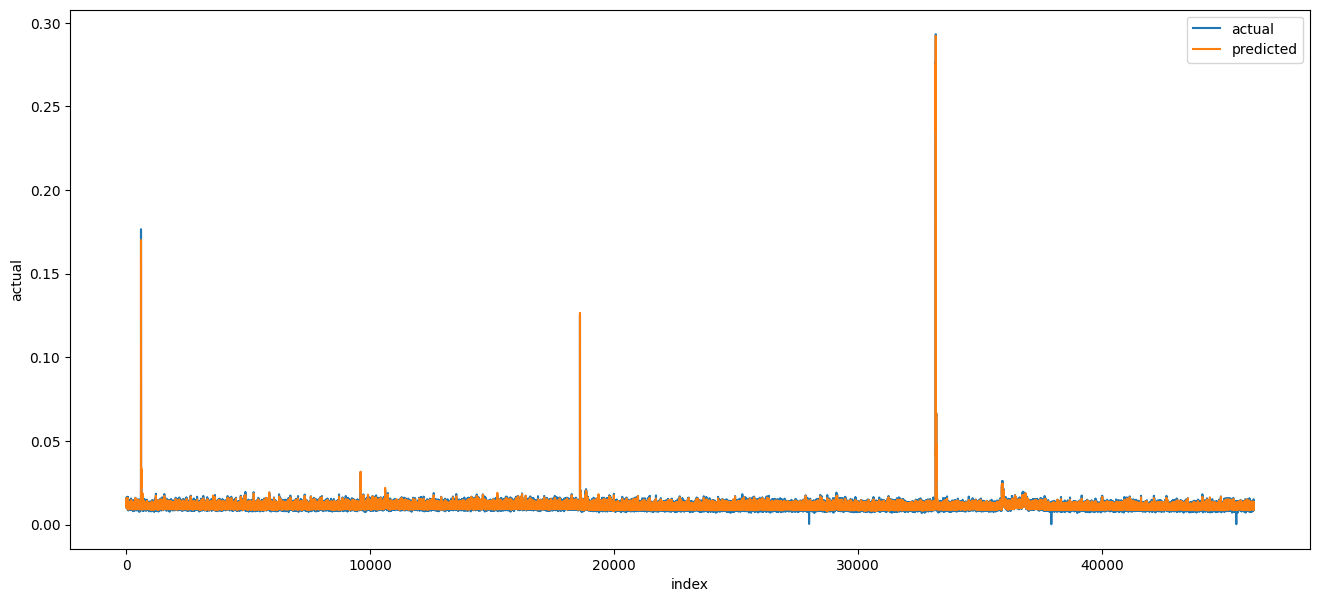

In [187]:
fig = plt.figure(figsize=(16, 7))
sns.lineplot(data=plotting_data, x='index', y='actual', label='actual')
sns.lineplot(data=plotting_data, x='index', y='predicted', label='predicted')
plt.legend()
plt.show()

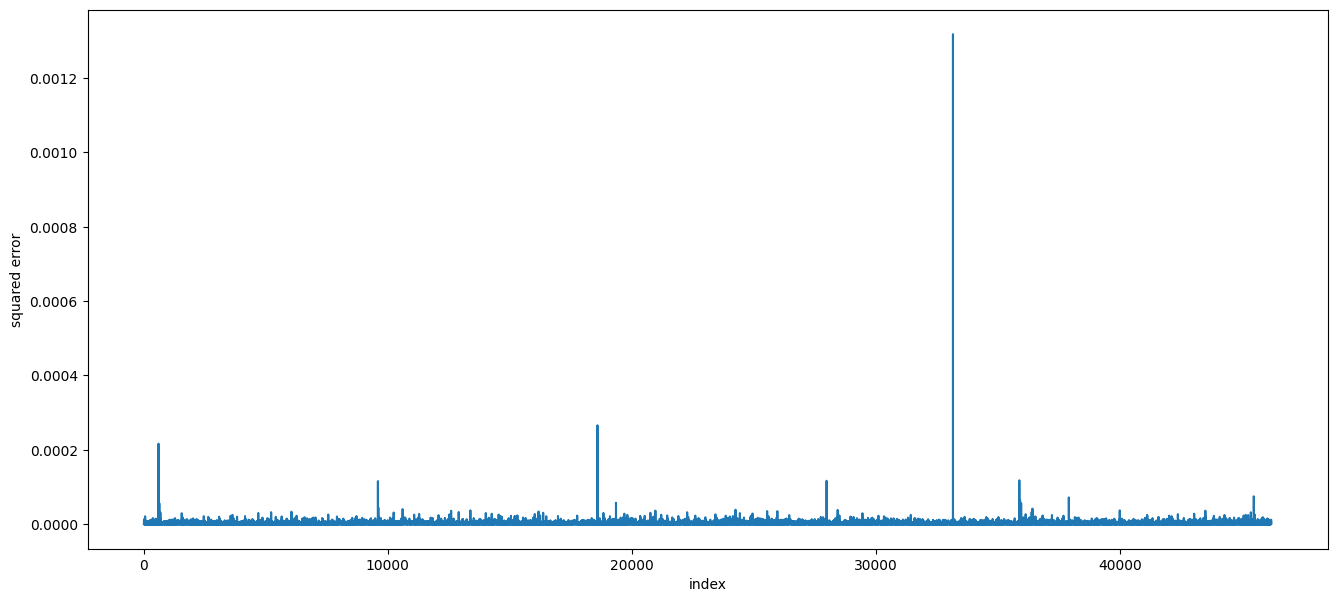

In [184]:
plt.figure(figsize=(16, 7))
sns.lineplot(data=plotting_data, x='index', y='squared error')
plt.show()

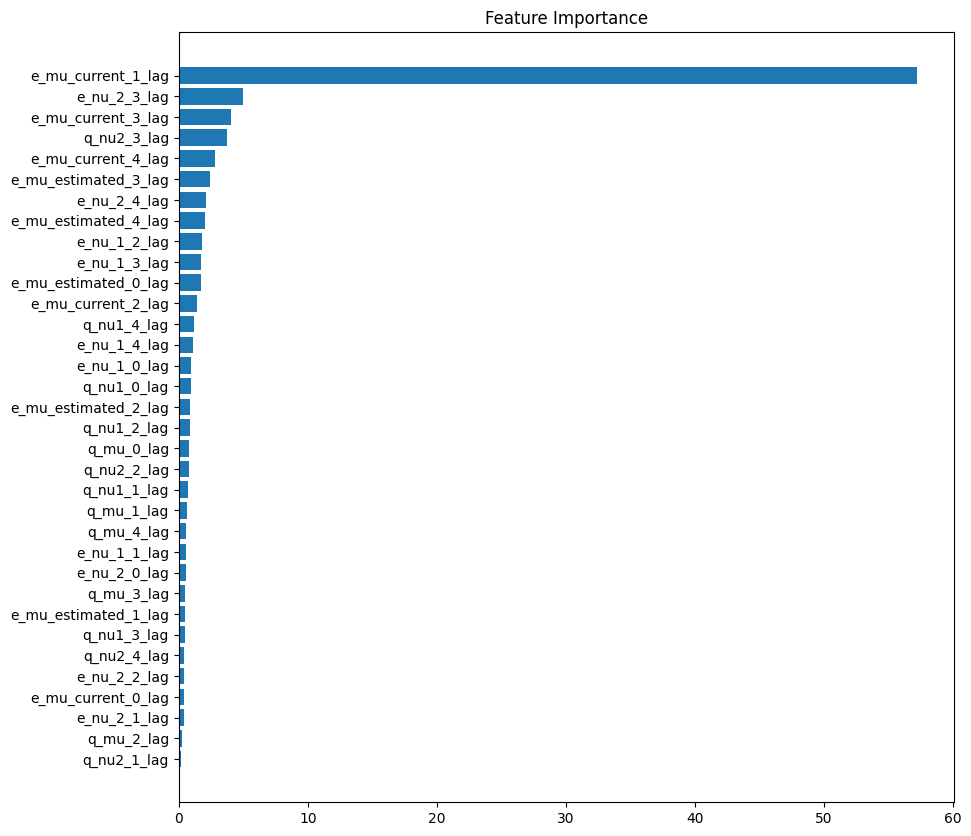

In [174]:
feature_importance = model.get_feature_importance()
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(10, 10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(train.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()